In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-data-for-psc-prediction/ML_Data.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense


2024-07-24 20:09:48.618927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 20:09:48.619026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 20:09:48.742900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SimpleRNN


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, Huber

In [11]:

# Load dataset
file_path = "/kaggle/input/ml-data-for-psc-prediction/ML_Data.csv"
data = pd.read_csv(file_path)

# Handle NaN values - fill with mean for numerical and mode for categorical
data.fillna(data.mean(numeric_only=True), inplace=True)
data.fillna(data.mode().iloc[0], inplace=True)

In [12]:
# Selected features

features = ['ETL electron affinity(eV)','Rshunt (ohm cm2)','VOC(V)', 'JSC(mA/cm2)', 'FF(%)']
target = 'PCE(%)'

In [13]:
# Split data into features and target
X = data[features]
y = data[target]

# Identify categorical and numerical features
categorical_features = []
numerical_features = [col for col in features if col not in categorical_features]



In [15]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

y = y.to_numpy()

# Reshape data for RNN (samples, timesteps, features)
X_preprocessed = np.expand_dims(X_preprocessed, axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [16]:
def build_rnn_model(input_shape, loss_function):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(64, activation='relu', return_sequences=False)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss=loss_function, metrics=['mae', 'mse'])
    return model

# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Build models with different loss functions
model_mae = build_rnn_model(input_shape, MeanAbsoluteError())
model_mse = build_rnn_model(input_shape, MeanSquaredError())
model_huber = build_rnn_model(input_shape, Huber())

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the models
history_mae = model_mae.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=2)
history_mse = model_mse.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=2)
history_huber = model_huber.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=2)


Epoch 1/100


I0000 00:00:1721851837.525679     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


817/817 - 13s - 16ms/step - loss: 1.1448 - mae: 1.1448 - mse: 3.3934 - val_loss: 0.3474 - val_mae: 0.3474 - val_mse: 0.3860
Epoch 2/100
817/817 - 2s - 2ms/step - loss: 0.7239 - mae: 0.7239 - mse: 1.0866 - val_loss: 0.2464 - val_mae: 0.2464 - val_mse: 0.2526
Epoch 3/100
817/817 - 2s - 2ms/step - loss: 0.6578 - mae: 0.6578 - mse: 0.8895 - val_loss: 0.2891 - val_mae: 0.2891 - val_mse: 0.2998
Epoch 4/100
817/817 - 1s - 2ms/step - loss: 0.6147 - mae: 0.6147 - mse: 0.7730 - val_loss: 0.3824 - val_mae: 0.3824 - val_mse: 0.3266
Epoch 5/100
817/817 - 1s - 2ms/step - loss: 0.5824 - mae: 0.5824 - mse: 0.6838 - val_loss: 0.2921 - val_mae: 0.2921 - val_mse: 0.2019
Epoch 6/100
817/817 - 1s - 2ms/step - loss: 0.5572 - mae: 0.5572 - mse: 0.6256 - val_loss: 0.3655 - val_mae: 0.3655 - val_mse: 0.2405
Epoch 7/100
817/817 - 2s - 2ms/step - loss: 0.5315 - mae: 0.5315 - mse: 0.5768 - val_loss: 0.1884 - val_mae: 0.1884 - val_mse: 0.1262
Epoch 8/100
817/817 - 1s - 2ms/step - loss: 0.5143 - mae: 0.5143 - mse: 

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
ANN MAE Model Performance:
  MAE: 0.1415
  MSE: 0.0727
  RMSE: 0.2696
  R2 Score: 0.9898
  Accuracy: 98.98%
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
ANN MSE Model Performance:
  MAE: 0.1621
  MSE: 0.0733
  RMSE: 0.2707
  R2 Score: 0.9897
  Accuracy: 98.97%
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
ANN Huber Model Performance:
  MAE: 0.1780
  MSE: 0.0810
  RMSE: 0.2845
  R2 Score: 0.9886
  Accuracy: 98.86%


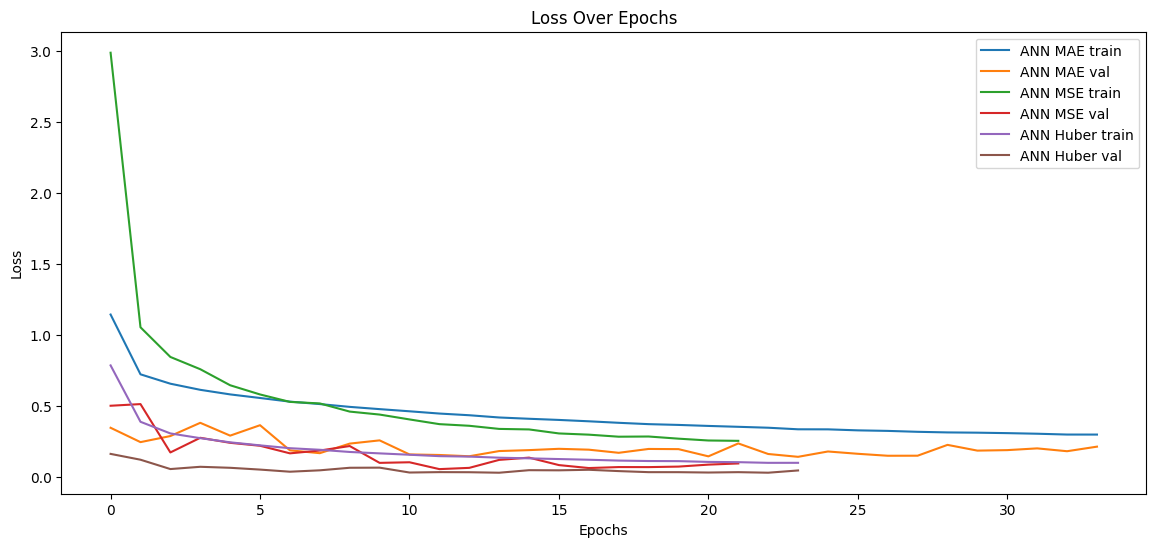

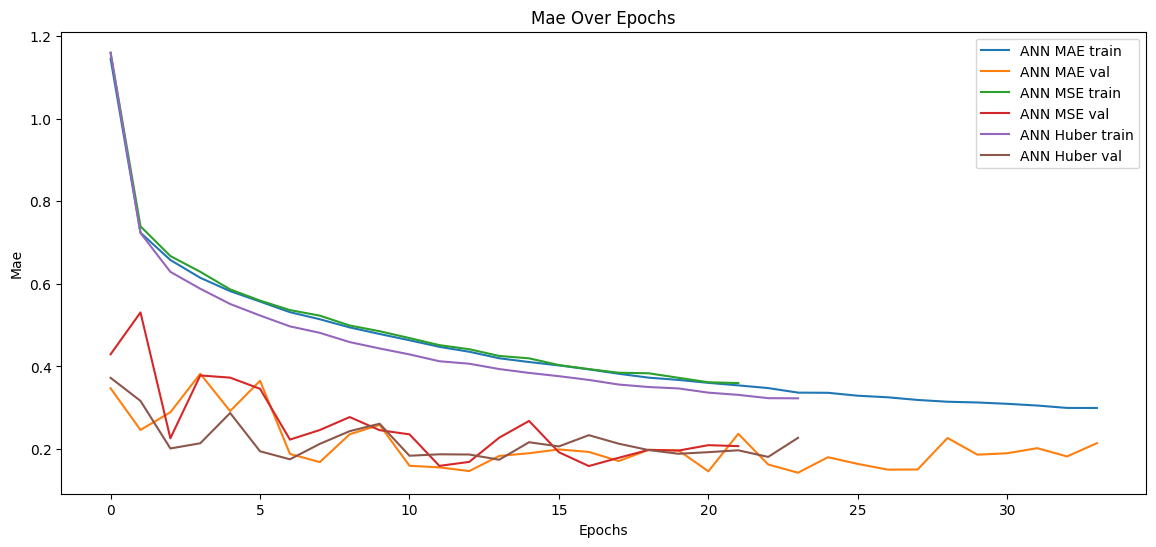

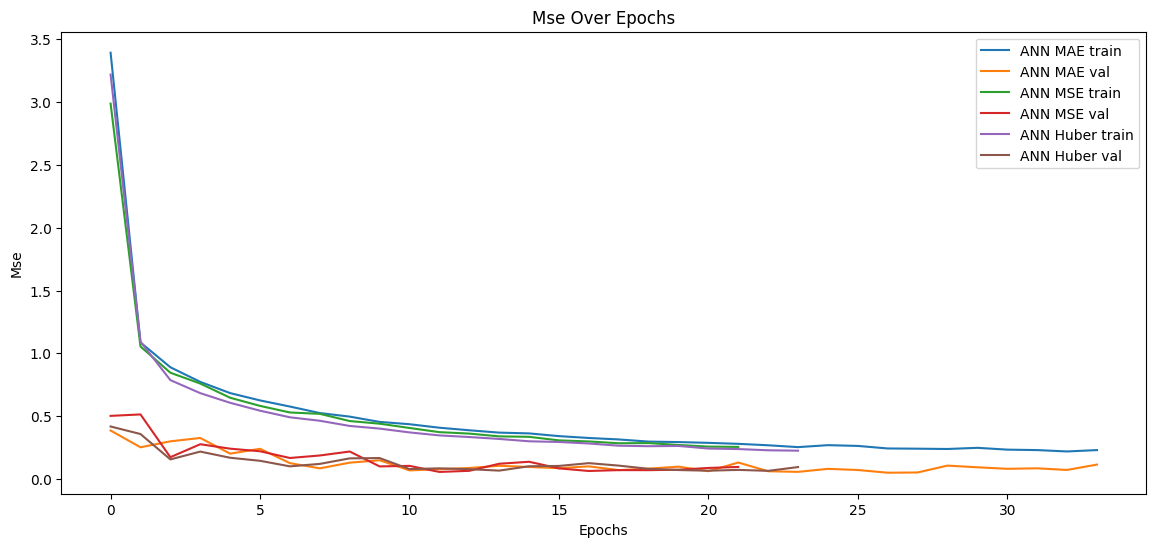

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


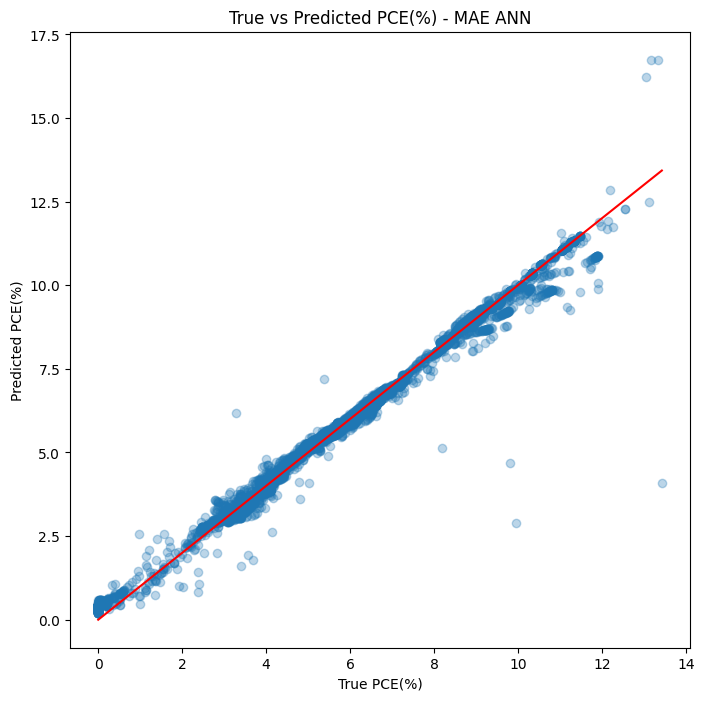

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


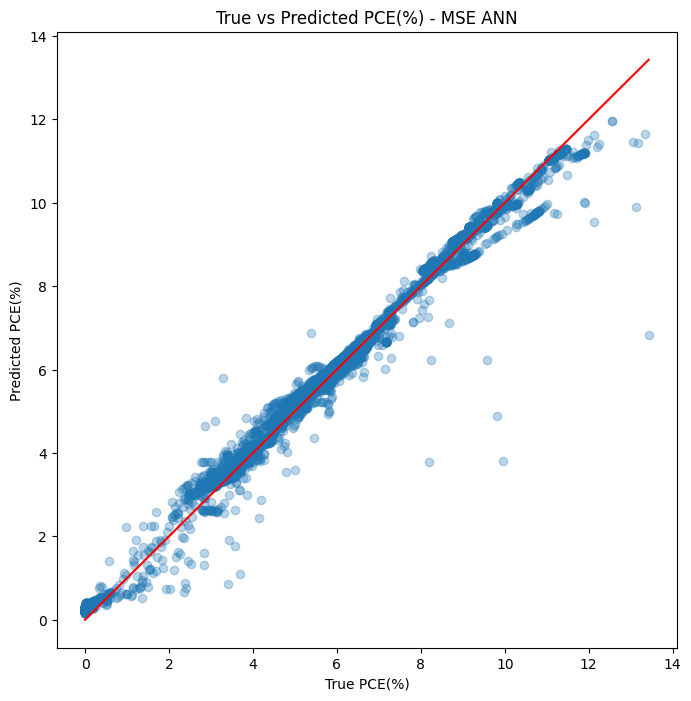

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


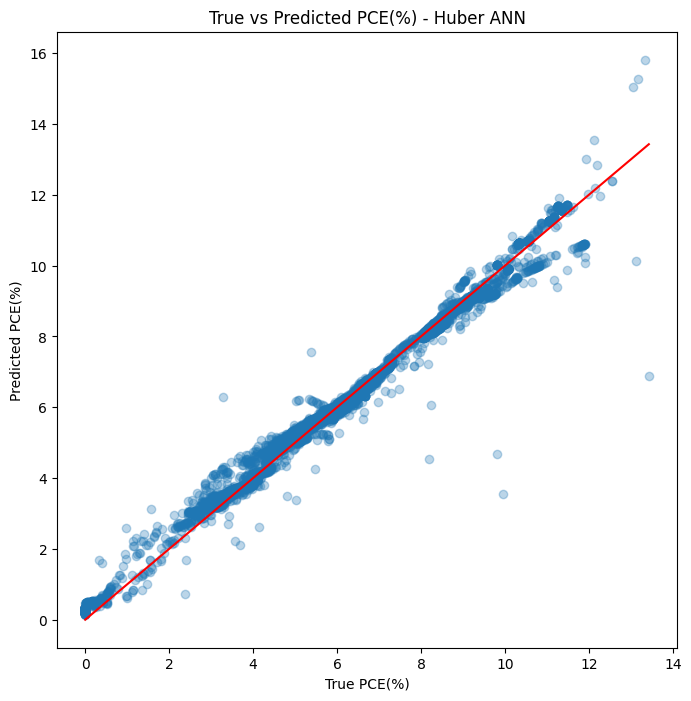

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate models
models = {'MAE': model_mae, 'MSE': model_mse, 'Huber': model_huber}
histories = {'MAE': history_mae, 'MSE': history_mse, 'Huber': history_huber}

# Function to evaluate and print model performance
def evaluate_models(models, X_test, y_test, label):
    for name, model in models.items():
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        accuracy = r2 * 100  # Convert R2 score to percentage
        print(f'{label} {name} Model Performance:')
        print(f'  MAE: {mae:.4f}')
        print(f'  MSE: {mse:.4f}')
        print(f'  RMSE: {rmse:.4f}')
        print(f'  R2 Score: {r2:.4f}')
        print(f'  Accuracy: {accuracy:.2f}%')

# Evaluate models
evaluate_models(models, X_test, y_test, 'ANN')

# Plot training history
def plot_history(histories, key='loss', label=''):
    plt.figure(figsize=(14, 6))
    for name, history in histories.items():
        plt.plot(history.history[key], label=f'{label} {name} train')
        plt.plot(history.history[f'val_{key}'], label=f'{label} {name} val')
    plt.xlabel('Epochs')
    plt.ylabel(key.capitalize())
    plt.legend()
    plt.title(f'{key.capitalize()} Over Epochs')
    plt.show()

# Plot training history
plot_history(histories, key='loss', label='ANN')
plot_history(histories, key='mae', label='ANN')
plot_history(histories, key='mse', label='ANN')

# Correlation between true data and predicted results
def plot_predictions(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.xlabel('True PCE(%)')
    plt.ylabel('Predicted PCE(%)')
    plt.title(title)
    plt.show()

# Plot predictions
for name, model in models.items():
    plot_predictions(model, X_test, y_test, f'True vs Predicted PCE(%) - {name} ANN')



256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


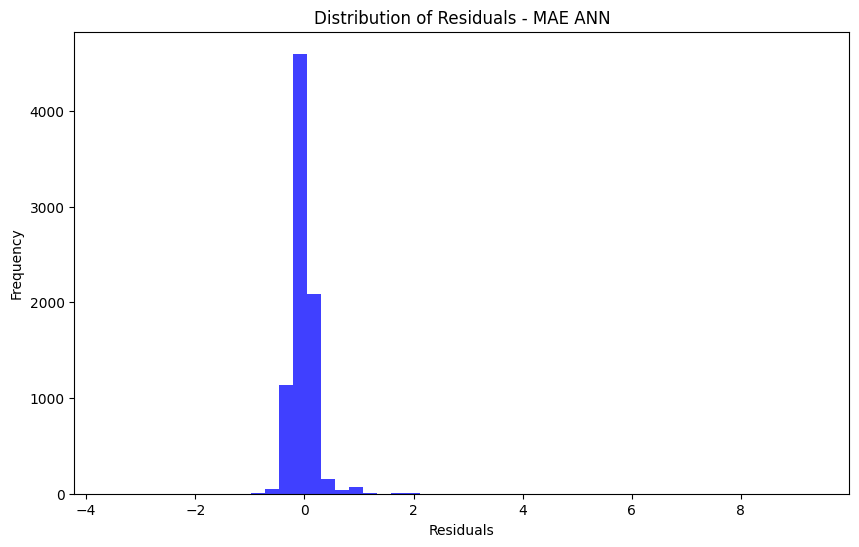

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


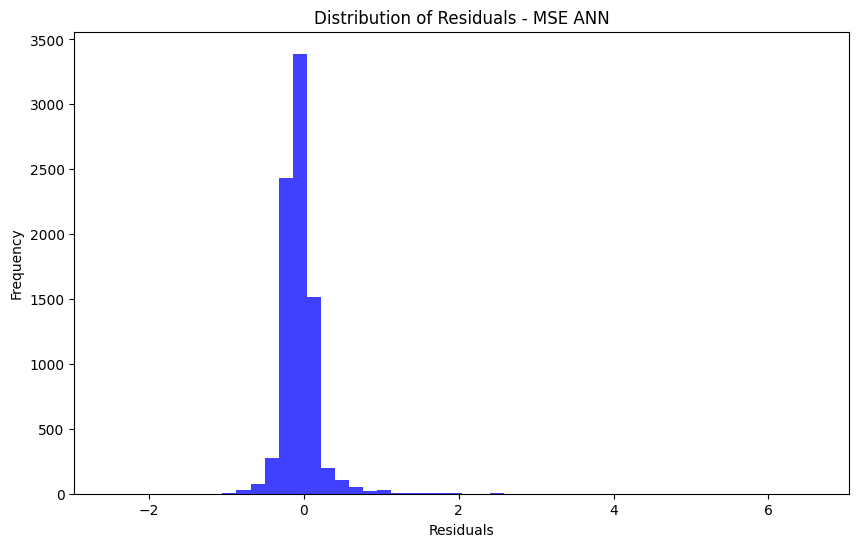

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


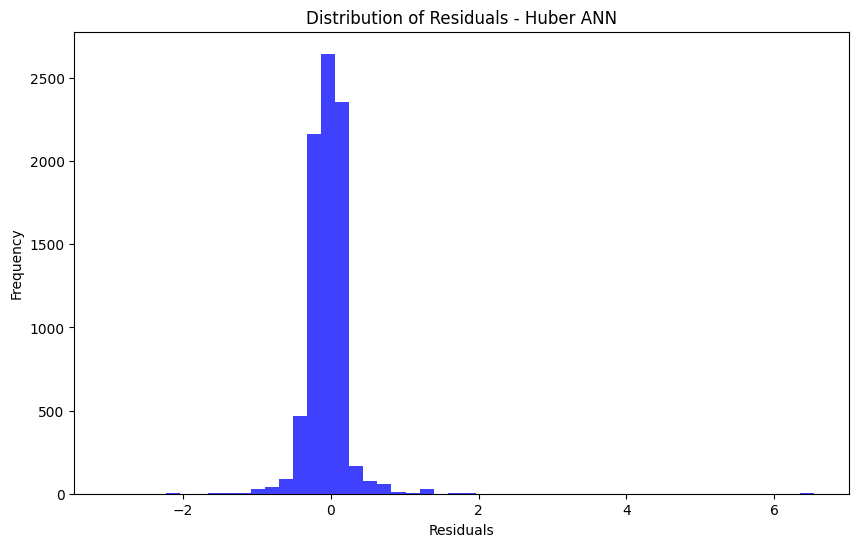

In [19]:
# Plot the distribution of differences between the predicted and true values
def plot_residuals(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred.flatten()
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=50, alpha=0.75, color='blue')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

# Plot residuals for each model
for name, model in models.items():
    plot_residuals(model, X_test, y_test, f'Distribution of Residuals - {name} ANN')
